In [1]:
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.stats import multivariate_normal
import time
import itertools
from re import sub
from decimal import Decimal
from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

from sklearn.externals import joblib
from sklearn import mixture

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
dfb = pd.read_csv('data/TorontoBusiness.csv')
dfr = pd.read_csv('data/TorontoReview.csv')

In [3]:
tfidf  = joblib.load('models/TFIDF_model.joblib')
svd    = joblib.load('models/SVD_model.joblib')
logreg = joblib.load('models/LogReg_model.joblib')

In [4]:
start_time = time.time()
est_sent = logreg.predict(svd.transform(tfidf.transform(dfr['clean_text'])))
print('--- {0} seconds ---'.format( time.time() - start_time ))
dfr['est_sentiment'] = est_sent

--- 25.220265865325928 seconds ---


In [5]:
dfal = pd.read_csv('data/AirbnbListings.csv.gz', compression='gzip')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
stop_words = set(stopwords.words('english'))
punct = list(string.punctuation)
ps = PorterStemmer()

def clean_text(text):
    if isinstance(text, str):
        for ch in punct:
            text = text.replace(ch, '')
        word_tokens = text.lower().split() 
        clean_text = [ps.stem(w) for w in word_tokens if not w in stop_words]
        ct = ' '.join(clean_text)
        return ct
    else:
        return None
dfal['clean_neighborhood_overview'] = dfal['neighborhood_overview'].progress_apply(clean_text)

# Provide keywords for Airbnb recommendations

In [7]:
kws = ['hipster','hipsters','hippie','hippy','art','arty','artistic','artists','artist']

## Identify data points and plot them

In [8]:
ps = PorterStemmer()
kws = [ps.stem(kw) for kw in kws]
kws = list(set(kws))

In [9]:
def n_keywords(text):
    N = 0
    if isinstance(text, str):
        for w in text.split():
            if w in kws:
                N += 1
    return N

In [10]:
dfr['kws_freq'] = dfr['stemmed_text'].progress_apply(n_keywords)
dfal['kws_freq'] = dfal['clean_neighborhood_overview'].progress_apply(n_keywords)

In [11]:
dfr = dfr[dfr['est_sentiment'] == 1]

In [12]:
dfb_tmp = dfr.groupby('business_id').sum()[['kws_freq']]

In [13]:
print(len(dfb_tmp))
print(len(dfb))

10394
10649


In [14]:
dfb1 = dfb.merge(dfb_tmp, how='right', on='business_id')
len(dfb1)

10394

In [15]:
# Ration between frequency of keywords appearance vs total review count
dfb1['kws_ratio'] = dfb1.kws_freq/dfb1.review_count

In [16]:
geo_yelp = dfb1[dfb1.kws_ratio > 0.1]
geo_yelp = geo_yelp[['longitude','latitude','kws_freq']]
geo_yelp['from'] = 'yelp'
geo_airbnb = dfal[dfal.kws_freq > 1]
geo_airbnb = geo_airbnb[['longitude','latitude','kws_freq']]
geo_airbnb['from'] = 'airbnb'

In [17]:
print(len(geo_yelp))
print(len(geo_airbnb))
geo_ya = pd.concat([geo_yelp,geo_airbnb], axis=0, ignore_index=True)
print(len(geo_ya))

434
305
739


In [18]:
geometry = [Point(xy) for xy in zip(geo_ya['longitude'], geo_ya['latitude'])]
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(geo_ya,crs=crs,geometry=geometry)

In [19]:
street_map = gpd.read_file('topo_edge_of_road_wgs84/TOPO_EDGE_OF_ROAD_WGS84.shp')

In [20]:
# fig, ax = plt.subplots(figsize=(17,17))
# street_map.plot(ax = ax, alpha = 1, color = 'grey')
# geo_df[geo_df['from']=='yelp'].plot(ax=ax,markersize=geo_df['kws_freq']*2,alpha=0.3,color='blue',marker='o', label='Yelp')
# geo_df[geo_df['from']=='airbnb'].plot(ax=ax,markersize=geo_df['kws_freq']*2,alpha=0.3,color='red',marker='o', label='Airbnb')
# plt.title('Data points associated to keywords', fontsize=30)
# plt.legend(fontsize=20)

## Exclude outliers

In [21]:
Xf = np.array(geo_ya[['longitude','latitude','kws_freq']])
X0 = []
for i in range(Xf.shape[0]):
    for j in range(int(Xf[i,2])):
        X0.append(list(Xf[i,0:2]))
X0 = np.array(X0)
print(X0.shape)
print(sum(Xf[:,2]))

(3327, 2)
3327.0


In [22]:
from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X0)
scrs = kde.score_samples(X0)

In [23]:
print(len(dfal))
dfal = dfal.dropna(subset=['longitude','latitude'])
print(len(dfal))

21900
21900


In [24]:
dfal['loc_scores_0'] = dfal.progress_apply(lambda x: kde.score_samples(np.array([[x.longitude,x.latitude]])), axis=1)

In [25]:
Radius = 1.1

In [26]:
X = X0[scrs >= Radius,:]
X1 = X0[scrs < Radius,:]
# plt.scatter(X[:,0],X[:,1], alpha = 0.05)
# plt.scatter(X1[:,0],X1[:,1], alpha = 0.05, color = 'red')
# plt.title('Data points associated to keywords')

In [27]:
dfal1 = dfal[dfal.loc_scores_0 < Radius].copy()
dfal = dfal[dfal.loc_scores_0 >= Radius].copy()
# plt.scatter(dfal.longitude,dfal.latitude, alpha = 0.05)
# plt.scatter(dfal1.longitude,dfal1.latitude, alpha = 0.05, color = 'red')
# plt.title('All Airbnb listings')

# Clustering

In [28]:
color_iter = itertools.cycle(['plum','peachpuff','lightsalmon', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'lightcoral','yellowgreen',
                              'lightgreen','dodgerblue','green'])

def plot_results_gmm(ax, X, Y_, means, covariances, index, dfal_):
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if dfal_.densities[i] < 100:
            continue
        ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 10, color=color, alpha = 0.4)
        ax.text(means[i,0],means[i,1], str(i) )

        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.4)
        ax.add_artist(ell)
        
def cluster_data_gmm(gmm,dfal):
    N_c = len(gmm.means_)
    dfal['cluster'] = dfal.apply(lambda x: gmm.predict(np.array([[x.longitude,x.latitude]]))[0], axis=1)
    dfal['price_float'] = dfal.apply(lambda x: float(Decimal(sub(r'[^\d.]', '', x.price))), axis=1)
    dfal_ = dfal.groupby('cluster').mean()[['price_float']]
    
    dens = np.zeros(N_c)
    frqs = np.zeros(N_c)
    for i in range(N_c):
        if i not in dfal_.index:
            dfal_.loc[i,:] = None
        frqs[i] = len(X[Y_ == i, 0])
        dens[i] = linalg.norm(linalg.inv(gmm.covariances_[i,:,:]))*frqs[i]*1e-4 

    dfal_ = dfal_.sort_index()
    dfal_['densities'] = dens
    dfal_['weights'] = gmm.weights_ 
    dfal_['kws_freqs'] = frqs
    return dfal_

### Bayesian Gaussian Mixture Model

In [29]:
N_clusters = 25

In [30]:
gmm = mixture.BayesianGaussianMixture(n_components=N_clusters, covariance_type='full', 
                                      weight_concentration_prior = 1, n_init = 5, max_iter = 1000, tol = 1e-3)
gmm.fit(X)
Y_ = gmm.predict(X)
print(gmm.converged_)
print(gmm.n_iter_)
dfal_ = cluster_data_gmm(gmm,dfal)
dfal_2 = dfal_[dfal_.densities >= 100].copy()

True
63


,price_float,densities,weights,kws_freqs
cluster,,,,
0,125.493584,384.611736,0.030012,94.0
1,128.734560,1735.043253,0.068187,188.0
2,223.392461,1686.031263,0.082622,270.0
3,164.091247,1200.961425,0.068784,217.0
4,143.484398,501.451565,0.048003,160.0
6,104.286765,116.811213,0.018714,61.0
7,172.298007,2950.002337,0.072207,254.0
8,127.853964,443.877383,0.028071,92.0
10,115.374083,5852.824273,0.080081,267.0


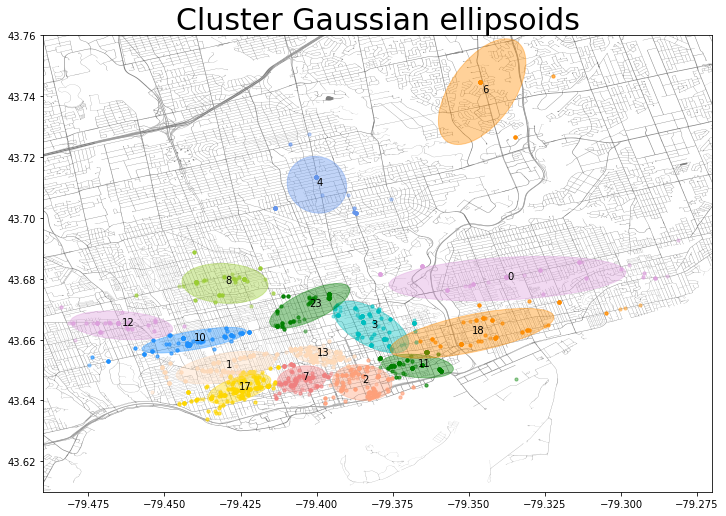

In [31]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax = ax, alpha = 1, color = 'grey')
plot_results_gmm(ax, X, Y_, gmm.means_, gmm.covariances_, 0, dfal_)
ax.set_xlim(-79.49, -79.27)
ax.set_ylim(43.61, 43.76)
plt.title('Cluster Gaussian ellipsoids', fontsize=30)
dfal_2